<a href="https://colab.research.google.com/github/will-cotton4/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/module3-model-interpretation/LS_DS_243_Model_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Model Interpretation

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
  - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
  - [Shapley Values](https://www.kaggle.com/dansbecker/shap-values)
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
  - [(Permutation) Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
  - [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
  - [Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- Random Forest Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

### Libraries
- [eli5](https://github.com/TeamHG-Memex/eli5): `conda install -c conda-forge eli5` / `pip install eli5`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [shap](https://github.com/slundberg/shap): `conda install -c conda-forge shap` / `pip install shap`

In [1]:
!pip install eli5
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 102kB 4.6MB/s 
     |████████████████████████████████| 57.7MB 403kB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 225kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [5]:
!pip install category-encoders

     |████████████████████████████████| 92kB 5.7MB/s 


### Library quirks to work around

1. Some of these libraries don't work with pipelines.

2. eli5 PermutationImportance + xgboost + pandas doesn't work, but [there's a work-around:](https://www.kaggle.com/dansbecker/permutation-importance#392299)

> Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".values or .as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work, [source](https://github.com/TeamHG-Memex/eli5/issues/256).

3. PDPbox _only_ works with pandas.

***[Data science is often about putting square pegs in round holes!](https://www.youtube.com/watch?v=ry55--J4_VQ)***

### 3 types of model explanations today!

#### Global explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### Global explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Lecture dataset: Lending Club

#### Can you predict if peer-to-peer loans are charged off or fully paid?

[Lending Club says,](https://www.lendingclub.com/) _"Our mission is to transform the banking system to make credit more affordable and investing more rewarding."_ You can view their [loan statistics and visualizations](https://www.lendingclub.com/info/demand-and-credit-profile.action).

[According to Wikipedia,](https://en.wikipedia.org/wiki/Lending_Club)

> Lending Club is the world's largest peer-to-peer lending platform. Lending Club enables borrowers to create unsecured personal loans between $1,000 and 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The data is a stratified sample of 100,000 Lending Club peer-to-peer loans with a loan status of "Charged Off" or "Fully Paid", issued from 2007 through 2018.

The set of variables included here are the intersection of what's available both when investors download historical data and when investors browse loans for manual investing.

Data dictionary: https://resources.lendingclub.com/LCDataDictionary.xlsx

Target: `charged_off`

**This is a classification problem, so we'll choose a [scoring metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) for classification: ROC AUC.**

**For our evaluation protocol, we'll choose cross-validation with independent test set.**

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


url = 'https://drive.google.com/uc?export=download&id=1AafT_i1dmfaxqKiyFofVndleKozbQw3l'
df = pd.read_csv(url)

X = df.drop(columns='charged_off')
y = df['charged_off']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=42)


def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [6]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   39.2s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   50.1s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa7850805f8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa7849ef2e8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [7]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7214766256277261


In [8]:
from sklearn.metrics import roc_auc_score
best = search.best_estimator_
X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7155068233276889


# 1a. Feature Importances
- Global explanation: all features in relation to each other
- Default, fastest, good for first estimates

[Here's some food for thought](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) about feature importances:

>**When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.** But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

For more information, see [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html).

<Figure size 360x864 with 0 Axes>

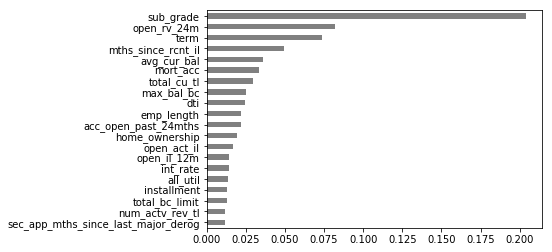

<Figure size 360x864 with 0 Axes>

In [14]:
#Use all features
# n = len(X_train.columns)
#Use 20 features
n = 20

figsize = (5,12)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
top_n.plot.barh(color='gray')
plt.figure(figsize=figsize)

# 1b. Drop-Column Importance
- Global explanation: all features in relation to each other
- The best in theory, but much too slow in practice

`sub_grade` is correlated with `int_rate`. If we drop `sub_grade`, the model uses other correlated features more, so the score remains similar.

In [13]:
from sklearn.model_selection import cross_val_score

X_train_no_subgrade = X_train.drop(columns='sub_grade')
new_model = XGBClassifier(max_depth=2, n_estimators=200, n_jobs=-1, random_state=42)

score_with = cross_val_score(new_model, X_train, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC with sub_grade:', score_with)

score_without = cross_val_score(new_model, X_train_no_subgrade, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC without sub_grade:', score_without)

print('Drop-Column Importance:', score_with - score_without)

Cross-Validation ROC AUC with sub_grade: 0.7210805152839438
Cross-Validation ROC AUC without sub_grade: 0.7192418242281939
Drop-Column Importance: 0.0018386910557498526


# 1c. Permutation Importance
- Global explanation: all features in relation to each other
- A good compromise!

Permutation Importance is a compromise between Feature Importance based on impurity reduction (which is the fastest) and Drop Column Importance (which is the "best.")

[The ELI5 library documentation explains,](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)

> Importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.
>
> To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. ...
>
>To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.
>
>The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Do-It-Yourself way, for intuition

In [15]:
X_test['sub_grade'].head()

5055     2.3
86027    2.2
86874    4.4
59692    4.2
47200    2.4
Name: sub_grade, dtype: float64

In [24]:
X_test_permuted = X_test.copy()
X_test_permuted['sub_grade'] = np.random.permutation(X_test_permuted['sub_grade'])
X_test_permuted['sub_grade'].head()

5055     2.1
86027    3.3
86874    3.4
59692    1.2
47200    1.5
Name: sub_grade, dtype: float64

**Shuffling the feature destroys the relationship between that feature and the other features/target.**

In [26]:
score_with = cross_val_score(new_model, X_train, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC with sub_grade:', score_with)

y_pred_proba = best.predict_proba(X_test_permuted.values)[:,1]
print('Test ROC AUC permuted:', roc_auc_score(y_test, y_pred_proba))

Cross-Validation ROC AUC with sub_grade: 0.7210805152839438
Test ROC AUC permuted: 0.6289067010180114


### With eli5 library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring = 'roc_auc', cv='prefit',
                                n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [31]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names = feature_names)

Weight,Feature
0.0937 ± 0.0015,sub_grade
0.0136 ± 0.0029,term
0.0060 ± 0.0002,dti
0.0036 ± 0.0005,acc_open_past_24mths
0.0027 ± 0.0003,installment
0.0024 ± 0.0010,emp_length
0.0020 ± 0.0004,emp_title_owner
0.0020 ± 0.0007,home_ownership
0.0017 ± 0.0005,mort_acc
0.0016 ± 0.0004,total_bc_limit


### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [33]:
print("Shape before removing features", X_train.shape)

Shape before removing features (80000, 98)


In [37]:
mask = permuter.feature_importances_>0

features=X_train.columns[mask]

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mort_acc',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_rev_accts',
       'num_sats', 'num_tl_120dpd_2m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_hi

In [38]:
# Refit the model after we remove features with zero importance

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   34.5s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   45.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   45.0s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa784e49da0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa7743302b0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [39]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7214766256277261


In [40]:
best = search.best_estimator_
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

NameError: ignored

# 2. Partial Dependence Plots

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

In [0]:
# TODO

### Explaining Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

### Partial Dependence Plots with 2 features, to see interactions

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdpbox.pdp.pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

In [0]:
# TODO

# 3. Shapley Values to explain individual predictions

[Dan Becker explains,](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [0]:
y_pred = (y_pred_proba >= 0.5).astype(int)
confidence = np.abs(y_pred_proba - 0.5)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head(10)

### True positive

In [0]:
# TODO

### True negative

In [0]:
# TODO

### False positive

In [0]:
# TODO

### False negative

In [0]:
# TODO

# ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values